<p>Implementing a decorator called 'train_time' that can be applied to a function to measure the execution time of the decorated function. The decorator is used to measure the training time of a machine learning model.</p>

<p>Measuring the training time of machine learning models is essential in the field of data to optimize resources, compare models and configurations, plan resources, optimize performance, and ensure the transparency and reproducibility of results. This helps improve the efficiency and quality of data modeling processes.</p>

In [46]:
def train_time(f):
    def wrapper(*args, **kwargs):
        start = datetime.now()
        print()
        clf, best_params = f(model=kwargs["model"], param_grid=kwargs["param_grid"], x_train=kwargs["x_train"], y_train=kwargs["y_train"])
        return datetime.now() - start, clf, best_params

    return wrapper

@train_time
def train_model(model, param_grid, x_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(x_train, y_train)
    best_params = grid_search.best_params_
    return grid_search.best_estimator_, best_params


def calculate_accuracy(model, y_test, x_test):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# HeartDisease Dataset - EDA

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from sklearn.decomposition import PCA

from datetime import datetime
from loguru import logger
import json

import warnings
warnings.filterwarnings('ignore')

palette = sns.color_palette(["#003959","#f46d43", "#106290", "#fdae61",  "#33a7e7", "#fee08b"])
sns.set_palette(sns.color_palette(palette))
sns.color_palette(palette)

[(0.0, 0.2235294117647059, 0.34901960784313724),
 (0.9568627450980393, 0.42745098039215684, 0.2627450980392157),
 (0.06274509803921569, 0.3843137254901961, 0.5647058823529412),
 (0.9921568627450981, 0.6823529411764706, 0.3803921568627451),
 (0.2, 0.6549019607843137, 0.9058823529411765),
 (0.996078431372549, 0.8784313725490196, 0.5450980392156862)]

- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

In [48]:
df = pd.read_csv('../input/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Age: Average of approximately 53.5 years, ranging from 28 to 77 years.

RestingBP: Average of 132.4, but with minimum values at zero, indicating inconsistencies.

Cholesterol: Average of 198.8, with values ranging from 0 to 603, which suggests anomalous values (cholesterol of 0 is unusual).

FastingBS: 23.3% of patients have elevated blood glucose levels (FastingBS = 1).

MaxHR: Average of 136.8 with a minimum of 60 and a maximum of 202.

Oldpeak: Ranges from -2.6 to 6.2, which is interesting and suggests a deeper analysis, as negative values can be rare.

HeartDisease: The average of 0.55 indicates that around 55% of patients have a diagnosis of heart disease.

In [49]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Let’s address the inconsistent values in RestingBP and Cholesterol by replacing the zero values with the median

In [51]:
median_restingbp = df['RestingBP'].median()
median_cholesterol = df['Cholesterol'].median()

df['RestingBP'] = df['RestingBP'].replace(0, median_restingbp)
df['Cholesterol'] = df['Cholesterol'].replace(0, median_cholesterol)

In [52]:
columns_numeric = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
columns_categoric = ['FastingBS', 'Sex', 'ChestPainType', 'RestingECG', 'ST_Slope', 'ExerciseAngina', 'HeartDisease']

- Numerical Features : Age, RestingBP, Cholesterol, MaxHR, Oldpeak
- Categorical Features : Sex, ChestPainType, FastingBS, RestingECG, ExerciseAngina, ST_Slope, HeartDisease

Histogram plot is a graph used to visualize the distribution of a dataset. It shows the frequency or the number of occurrences of different values within a continuous set of data. The histogram is employed to identify patterns, trends, and insights in the data, making it useful in areas such as statistics, data analysis, and engineering. It assists in identifying the shape of the distribution, detecting outliers, data segmentation, trend analysis, performance evaluation, and making informed decisions.

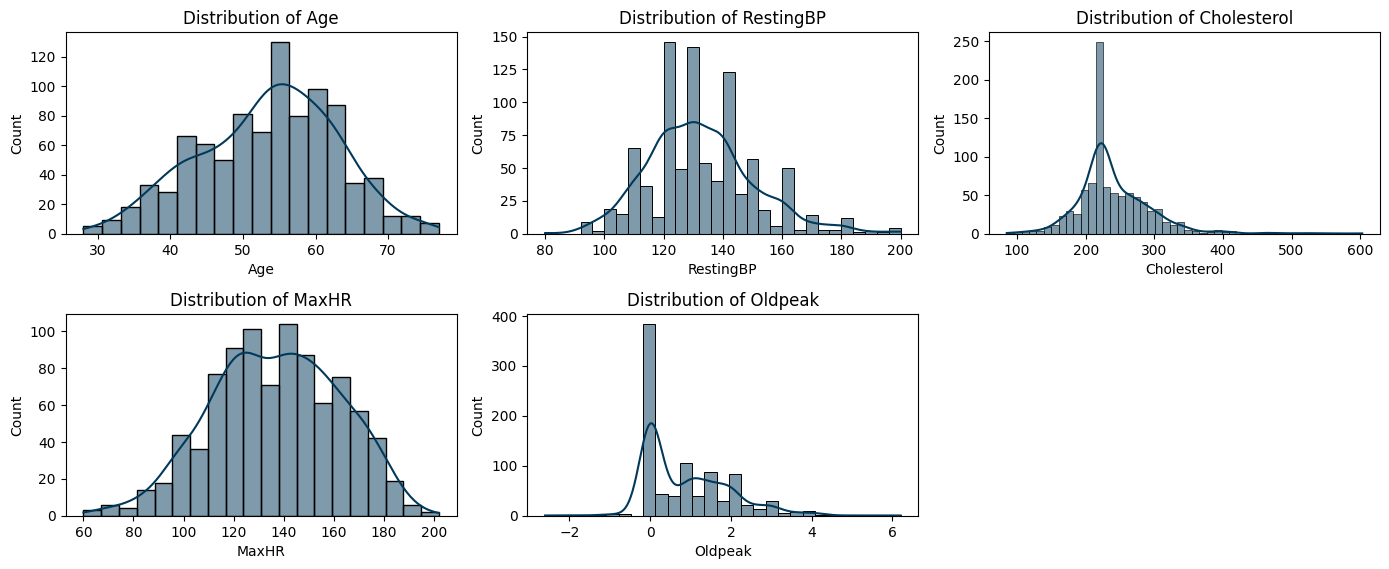

In [53]:
fig, axes = plt.subplots(4, 3, figsize=(14, 11))
titles = ['Distribution of ' + col for col in columns_numeric]
for i, col in enumerate(columns_numeric):
    sns.histplot(x=df[col], kde=True, ax=axes[i // 3, i % 3]).set(title=titles[i])
for j in range(i + 1, len(axes.flat)):
    fig.delaxes(axes.flat[j])
plt.tight_layout()
plt.show()

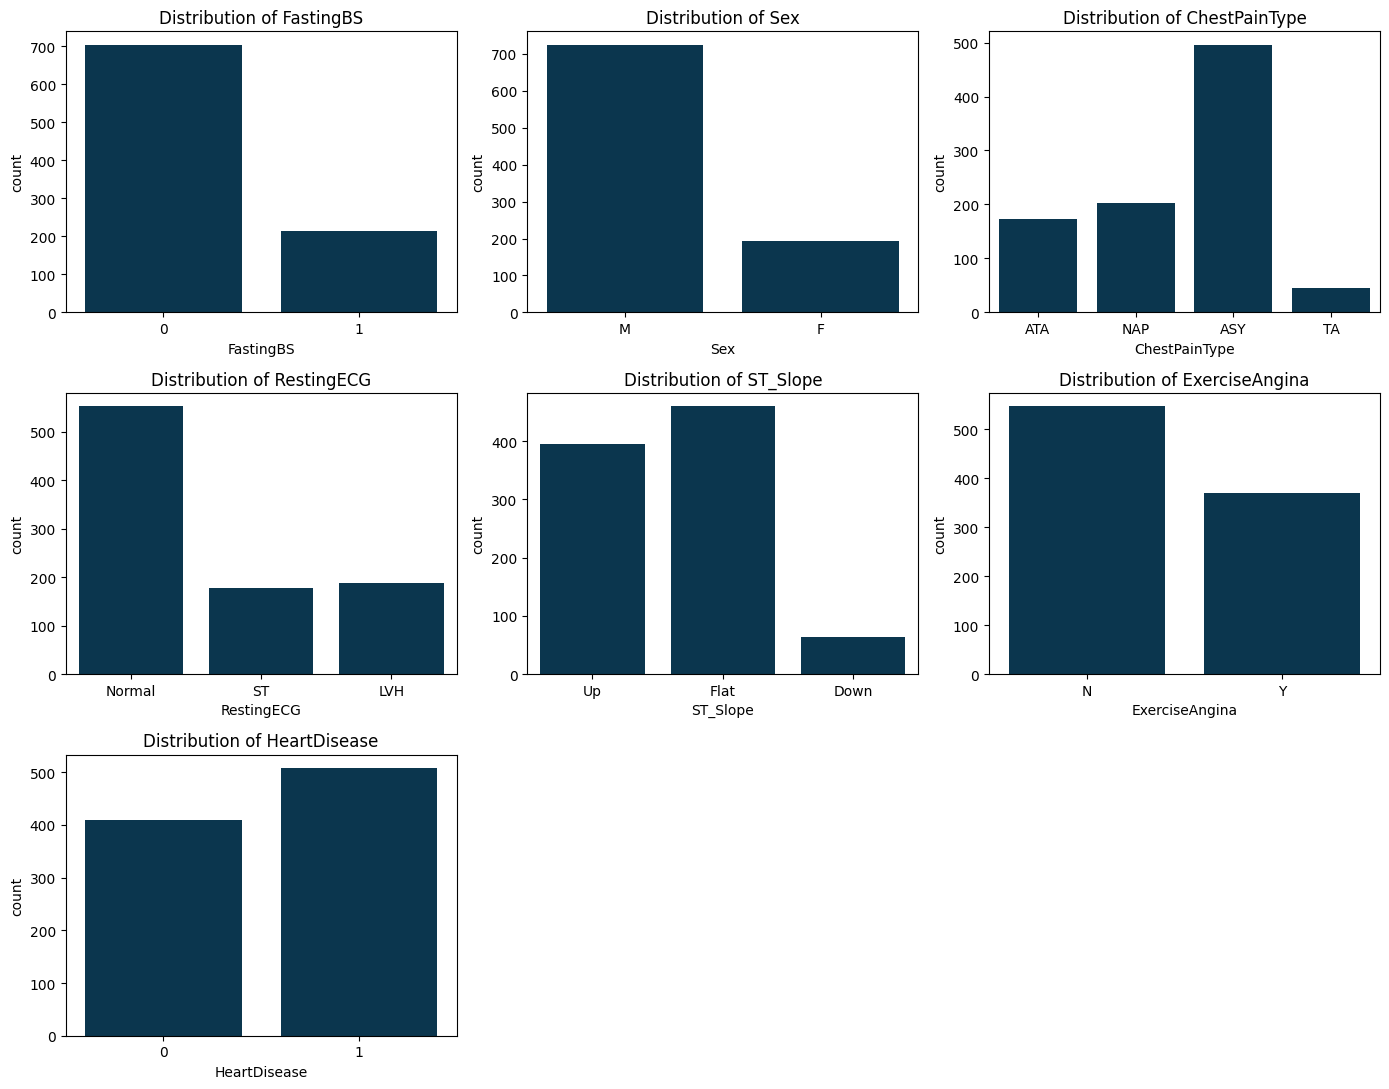

In [54]:
fig, axes = plt.subplots(3, 3, figsize=(14, 11))
titles = ['Distribution of ' + col for col in columns_categoric]
for i, col in enumerate(columns_categoric):
    sns.countplot(x=df[col], ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set(title=titles[i])
for j in range(i + 1, len(axes.flat)):
    fig.delaxes(axes.flat[j])
plt.tight_layout()
plt.show()

Age: Patients with heart disease tend to be older, indicating that the risk of developing the condition increases with age.

Resting Blood Pressure: Elevated blood pressure levels are often observed in patients with heart disease, pointing to an association with increased cardiovascular risk.

Cholesterol: Patients with heart disease have, on average, higher cholesterol levels, suggesting that hypercholesterolemia is a significant risk factor for this condition.

Maximum Heart Rate: On average, maximum heart rate (MaxHR) is lower in patients with heart disease, which may indicate reduced cardiac capacity.

Oldpeak: Elevated Oldpeak values in patients with heart disease reflect a higher level of cardiac stress, which is associated with a higher cardiovascular risk.

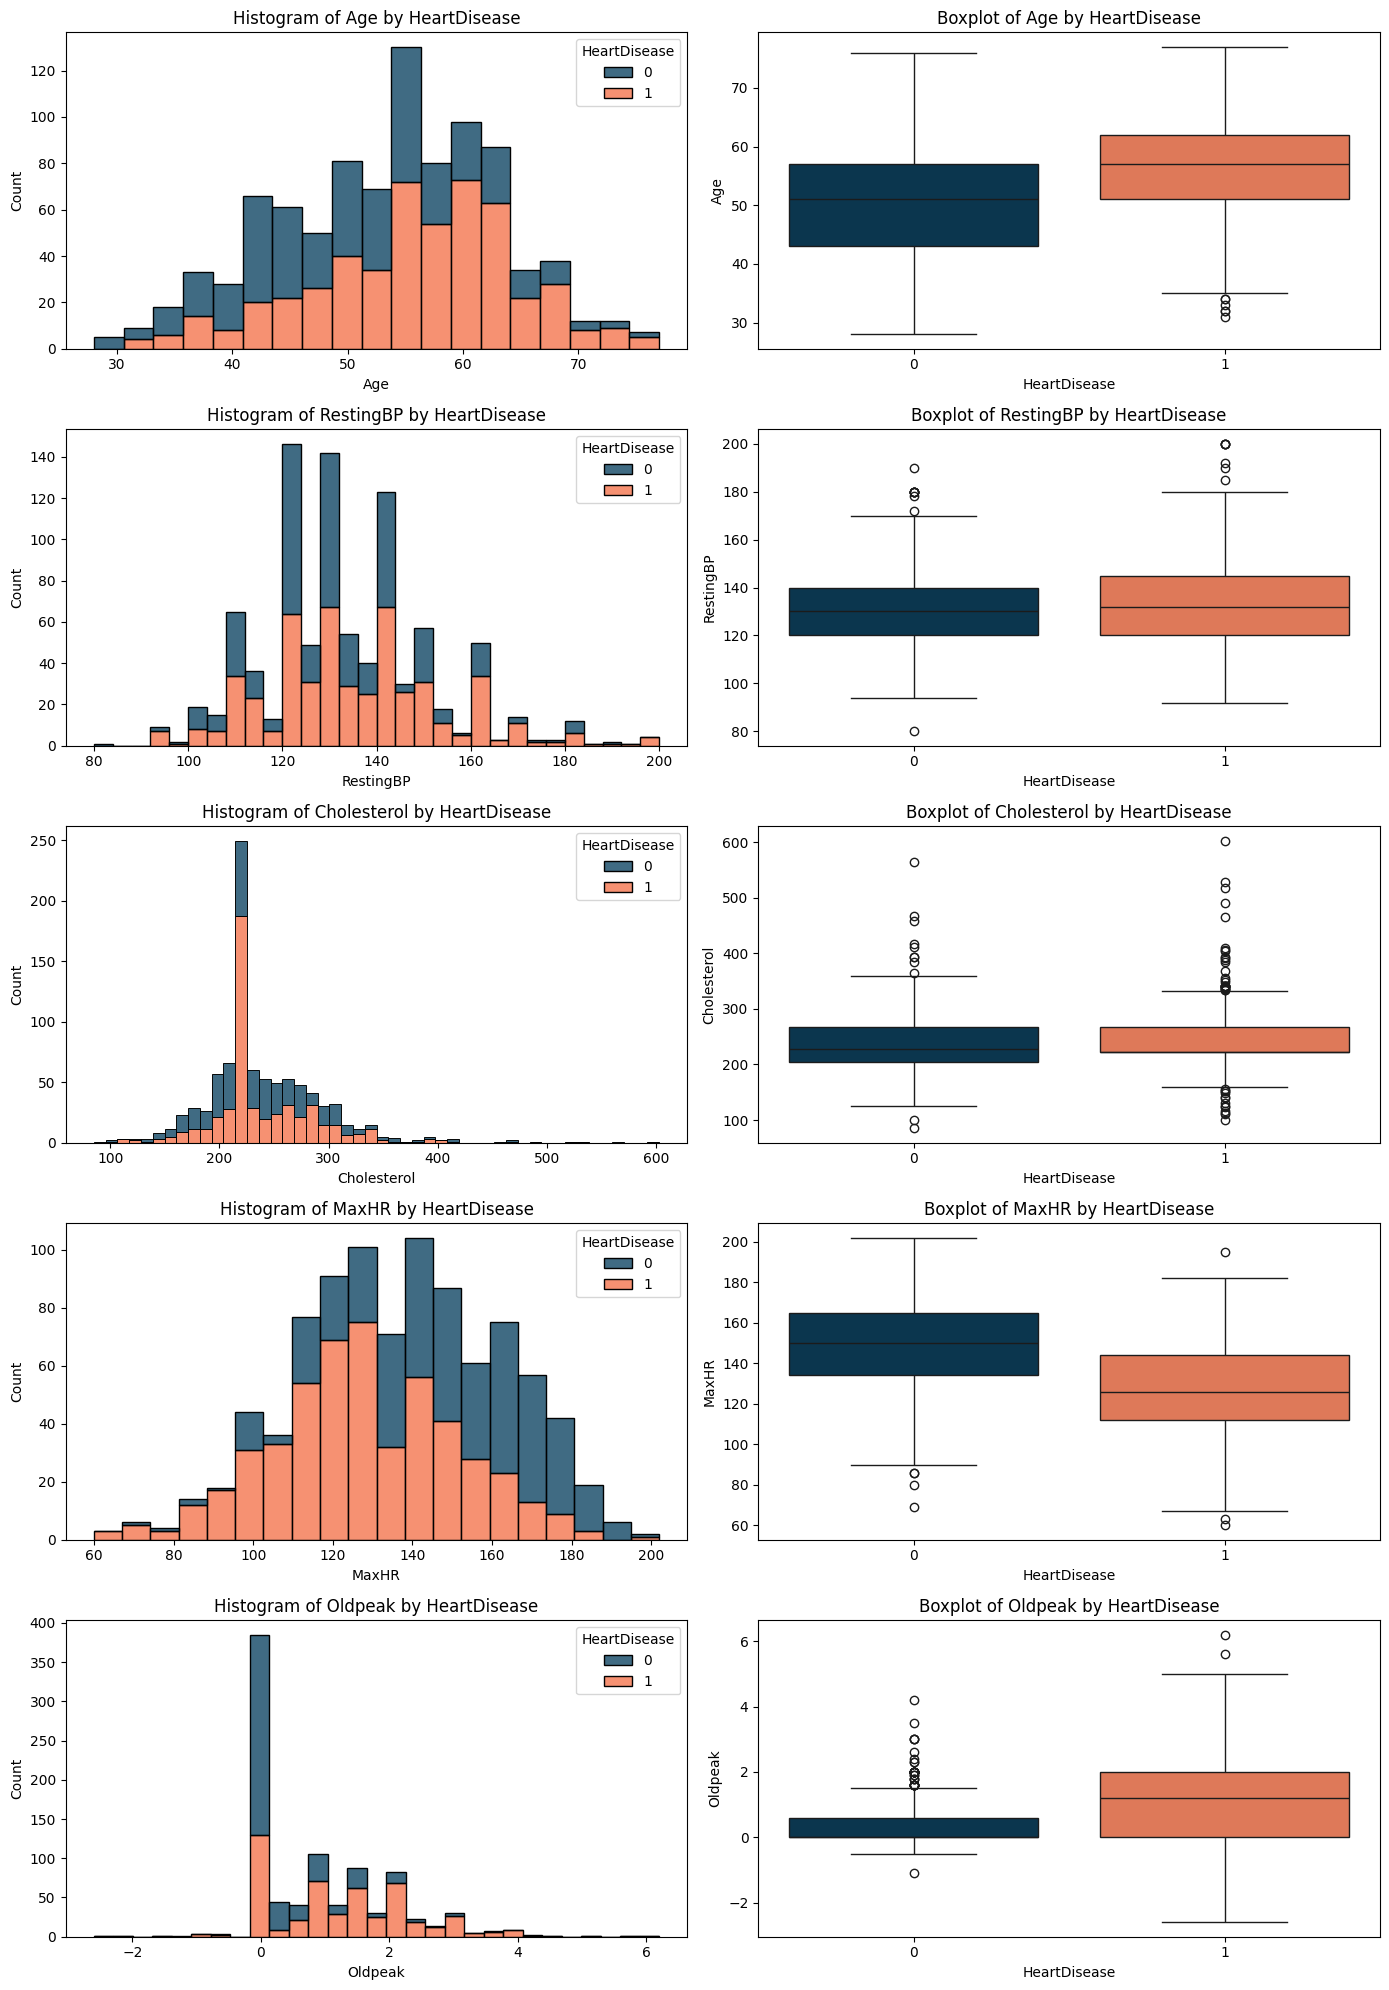

In [55]:
fig, axes = plt.subplots(len(columns_numeric), 2, figsize=(14, len(columns_numeric) * 4))
for i, col in enumerate(columns_numeric):
    sns.histplot(data=df, x=col, hue='HeartDisease', multiple='stack', ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {col} by HeartDisease')
    sns.boxplot(data=df, x='HeartDisease', y=col, ax=axes[i, 1], palette=palette)
    axes[i, 1].set_title(f'Boxplot of {col} by HeartDisease')
plt.tight_layout()
plt.show()

FastingBS: indicates high blood sugar levels, associated with increased cardiac risk.

Sex: Predominantly male, with a generally higher incidence of heart disease in men.

ChestPainType: ASY (asymptomatic) is the most common, followed by NAP, ATA, and TA. Asymptomatic individuals have a higher prevalence of heart disease, while less severe anginas present a lower risk.

RestingECG: Most patients have a normal ECG, followed by ST and LVH. Variations in the ECG, such as left ventricular hypertrophy, may indicate increased risk.

Exercise Angina: Patients with exercise-induced angina tend to present more cases of heart disease.

ST_Slope: The ST slope also provides insights, with Flat associated with higher risk.

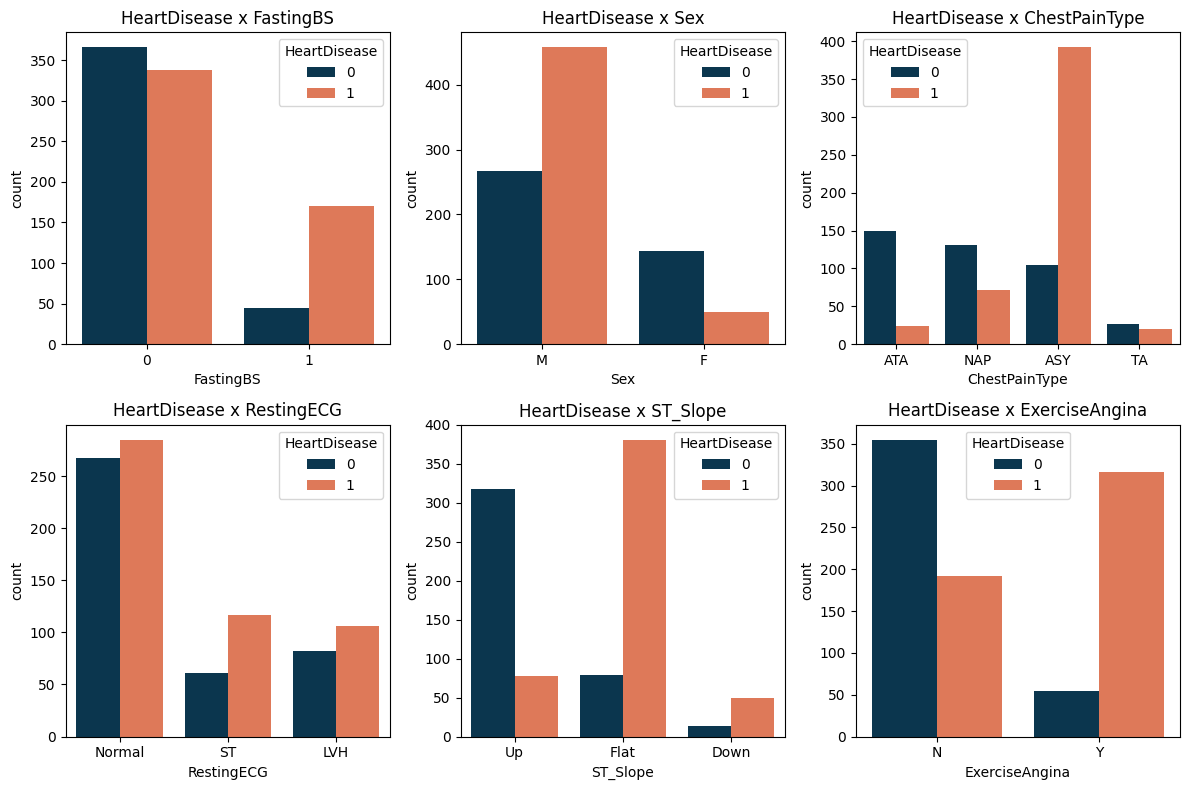

In [56]:
columns_c = [col for col in columns_categoric if col != 'HeartDisease']
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
titles = ['HeartDisease x ' + col for col in columns_c]
for i, col in enumerate(columns_c):
    sns.countplot(data=df, x=col, hue='HeartDisease', ax=axes[i // 3, i % 3]).set_title(titles[i])
plt.tight_layout()
plt.show()

# Machine Learning

In [57]:
le = LabelEncoder()
feature = ['Sex', 'ChestPainType', 'RestingECG', 'ST_Slope', 'ExerciseAngina']
for col in feature:
    df[col] = le.fit_transform(df[col])

A correlation matrix is a table that shows the relationship between different variables in a dataset. It helps to identify whether the variables move together, in opposite directions, or have no relationship with each other. The values in the matrix range from -1 to 1, where 1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation, and 0 indicates no correlation. It is a useful tool for understanding patterns and trends in the data.

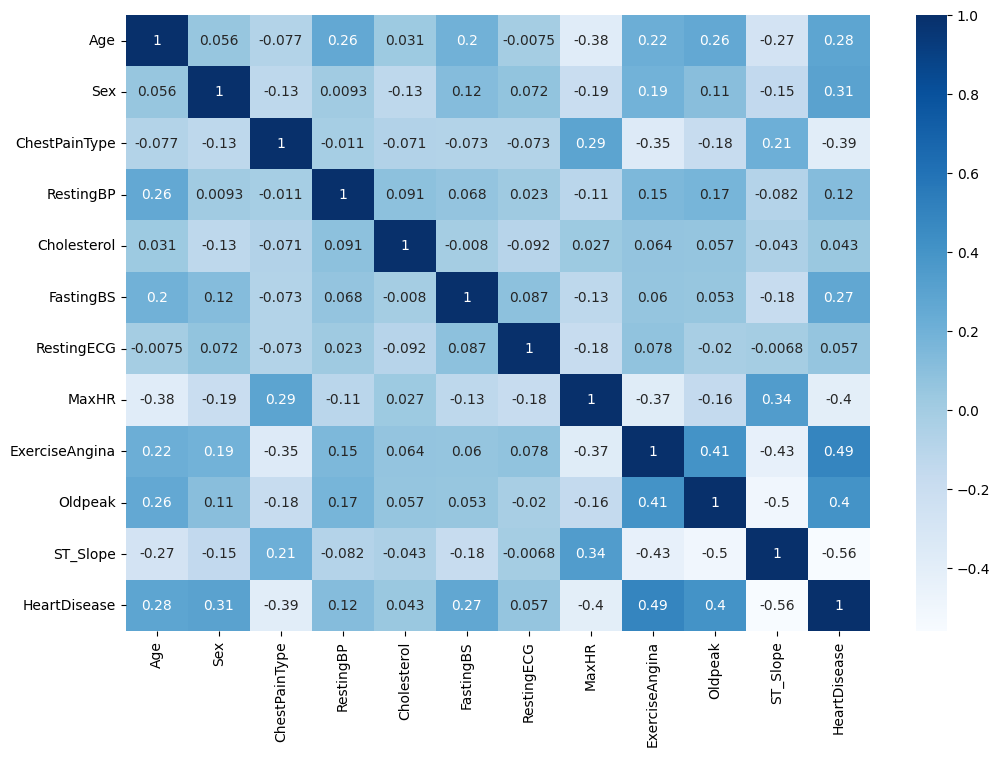

In [58]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='Blues')
plt.show()

In [59]:
ss = StandardScaler()
df['Oldpeak'] = ss.fit_transform(df[['Oldpeak']])
df['RestingBP'] = ss.fit_transform(df[['RestingBP']])
df['Age'] = ss.fit_transform(df[['Age']])
df['Cholesterol'] = ss.fit_transform(df[['Cholesterol']])
df['MaxHR'] = ss.fit_transform(df[['MaxHR']])
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,1,1,0.415002,0.897407,0,1,1.382928,0,-0.832432,2,0
1,-0.478484,0,2,1.527329,-1.122849,0,1,0.754157,0,0.105664,1,1
2,-1.751359,1,1,-0.141161,0.786200,0,2,-1.525138,0,-0.832432,2,0
3,-0.584556,0,0,0.303769,-0.492677,0,1,-1.132156,1,0.574711,1,1
4,0.051881,1,2,0.971166,-0.844832,0,1,-0.581981,0,-0.832432,2,0


In [60]:
x = df.drop(['HeartDisease'], axis=1)
y = df['HeartDisease']

In [61]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## GridSearchCV
<p>GridSearchCV is a technique for finding the best combination of hyperparameters for a machine learning model. It tests all possible combinations of hyperparameters, evaluating each one using cross-validation. The model with the best average performance is selected as the final result. GridSearchCV helps optimize the model's performance, but it can be computationally intensive.<p>
<p>This code automates the training and evaluation of multiple classification models using different parameters for each model. Through the loop and the models_list, the results are stored for each model, allowing for the comparison of model performances and the selection of the one that achieved the best performance for the specific classification task at hand. This facilitates the process of experimenting with various models and hyperparameters, making the development of a machine learning model more efficient and scalable.<p>

In [62]:
models_list = list()

models = [
    {'name': 'SVM', 'model': SVC(), 'param_grid': {'C': [0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3],
                                                   'gamma': [0.7, 0.8, 0.9, 1, 1.1, 1.2],
                                                   'kernel': ['linear', 'rbf']}},

    {'name': 'Random Forest', 'model': RandomForestClassifier(), 'param_grid': {'n_estimators': [10, 50, 100, 500, 1000],
                                                                                'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                                                                                'criterion': ['gini', 'entropy', 'log_loss']}},

    {'name': 'K-Nearest Neighbors', 'model': KNeighborsClassifier(), 'param_grid': {'n_neighbors': [3, 5, 7],
                                                                                    'p': [1, 2],'weights': ['uniform', 'distance'],
                                                                                    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                                                                                    'leaf_size': [10, 20, 30],
                                                                                    'metric': ['euclidean', 'manhattan', 'chebyshev'],
                                                                                    'n_jobs': [-1]}},

    {'name': 'Decision Tree', 'model': DecisionTreeClassifier(), 'param_grid': {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                                                                                'min_samples_split': [2, 5, 10]}},

    {'name': 'AdaBoost', 'model': AdaBoostClassifier(), 'param_grid': {'n_estimators': [50, 100, 200, 500],
                                                                       'learning_rate': [0.1, 0.5, 1.0],
                                                                       'algorithm': ['SAMME', 'SAMME.R']}},

    {'name': 'Gradient Boosting', 'model': GradientBoostingClassifier(), 'param_grid': {'n_estimators': [50, 100, 200, 500],
                                                                                         'learning_rate': [0.1, 0.5, 1.0],
                                                                                         'max_depth': [3, 4, 5],
                                                                                         'subsample': [0.8, 1.0]}},

    {'name': 'Logistic Regression', 'model': LogisticRegression(), 'param_grid': {'C': [0.1, 0.5, 1.0, 1.5, 2.0],
                                                                                   'solver': ['liblinear', 'saga'],
                                                                                   'penalty': ['l1', 'l2', 'elasticnet'],
                                                                                   'l1_ratio': [0.1, 0.5, 0.9]}},

    {'name': 'XGBoost', 'model': XGBClassifier(), 'param_grid': {'max_depth': [3, 4, 5, 6, 7],
                                                                 'learning_rate': [0.1, 0.01, 0.001],
                                                                 'n_estimators': [50, 100, 200, 500],
                                                                 'subsample': [0.8, 1.0],
                                                                 'colsample_bytree': [0.6, 0.8, 1.0]}},

    {'name': 'Naive Bayes', 'model': GaussianNB(), 'param_grid': {}}
]

for model_info in models:
    model_name = model_info.get("name")
    model = model_info.get("model")
    param_grid = model_info.get("param_grid")

    logger.info(f"Training Model {model_name}")

    time_to_train, clf, best_params = train_model(model=model, param_grid=param_grid, x_train=x_train, y_train=y_train)
    predicted_labels = clf.predict(x_test)
    accuracy = accuracy_score(y_test, predicted_labels)
    logger.info(f"Time to train model {time_to_train}")
    logger.info(f"Model accuracy {model_name}: {accuracy}")
    logger.info(f"Best Model Params {json.dumps(best_params, indent=4)}")

    result_model_info = {
        "model_name": model_name,
        "model_instance": clf,
        "model_accuracy": accuracy,
        "train_time": time_to_train,
    }

    models_list.append(result_model_info)

2024-11-03 22:34:48.050 | INFO     | __main__:<module>:50 - Training Model SVM


2024-11-03 22:34:52.329 | INFO     | __main__:<module>:55 - Time to train model 0:00:04.275621
2024-11-03 22:34:52.330 | INFO     | __main__:<module>:56 - Model accuracy SVM: 0.8623188405797102
2024-11-03 22:34:52.330 | INFO     | __main__:<module>:57 - Best Model Params {
    "C": 0.9,
    "gamma": 0.7,
    "kernel": "linear"
}
2024-11-03 22:34:52.330 | INFO     | __main__:<module>:50 - Training Model Random Forest


2024-11-03 22:35:28.272 | INFO     | __main__:<module>:55 - Time to train model 0:00:35.937379
2024-11-03 22:35:28.273 | INFO     | __main__:<module>:56 - Model accuracy Random Forest: 0.8695652173913043
2024-11-03 22:35:28.274 | INFO     | __main__:<module>:57 - Best Model Params {
    "criterion": "log_loss",
    "max_depth": 7,
    "n_estimators": 50
}
2024-11-03 22:35:28.274 | INFO     | __main__:<module>:50 - Training Model K-Nearest Neighbors


2024-11-03 22:35:33.030 | INFO     | __main__:<module>:55 - Time to train model 0:00:04.738539
2024-11-03 22:35:33.030 | INFO     | __main__:<module>:56 - Model accuracy K-Nearest Neighbors: 0.8586956521739131
2024-11-03 22:35:33.030 | INFO     | __main__:<module>:57 - Best Model Params {
    "algorithm": "auto",
    "leaf_size": 10,
    "metric": "manhattan",
    "n_jobs": -1,
    "n_neighbors": 5,
    "p": 1,
    "weights": "distance"
}
2024-11-03 22:35:33.031 | INFO     | __main__:<module>:50 - Training Model Decision Tree
2024-11-03 22:35:33.159 | INFO     | __main__:<module>:55 - Time to train model 0:00:00.127172
2024-11-03 22:35:33.160 | INFO     | __main__:<module>:56 - Model accuracy Decision Tree: 0.8333333333333334
2024-11-03 22:35:33.160 | INFO     | __main__:<module>:57 - Best Model Params {
    "max_depth": 3,
    "min_samples_split": 2
}
2024-11-03 22:35:33.160 | INFO     | __main__:<module>:50 - Training Model AdaBoost


2024-11-03 22:35:38.330 | INFO     | __main__:<module>:55 - Time to train model 0:00:05.152367
2024-11-03 22:35:38.331 | INFO     | __main__:<module>:56 - Model accuracy AdaBoost: 0.8478260869565217
2024-11-03 22:35:38.331 | INFO     | __main__:<module>:57 - Best Model Params {
    "algorithm": "SAMME",
    "learning_rate": 0.1,
    "n_estimators": 200
}
2024-11-03 22:35:38.332 | INFO     | __main__:<module>:50 - Training Model Gradient Boosting


2024-11-03 22:35:50.538 | INFO     | __main__:<module>:55 - Time to train model 0:00:12.203857
2024-11-03 22:35:50.539 | INFO     | __main__:<module>:56 - Model accuracy Gradient Boosting: 0.8333333333333334
2024-11-03 22:35:50.539 | INFO     | __main__:<module>:57 - Best Model Params {
    "learning_rate": 0.1,
    "max_depth": 3,
    "n_estimators": 50,
    "subsample": 1.0
}
2024-11-03 22:35:50.540 | INFO     | __main__:<module>:50 - Training Model Logistic Regression


2024-11-03 22:35:50.927 | INFO     | __main__:<module>:55 - Time to train model 0:00:00.386129
2024-11-03 22:35:50.928 | INFO     | __main__:<module>:56 - Model accuracy Logistic Regression: 0.8623188405797102
2024-11-03 22:35:50.928 | INFO     | __main__:<module>:57 - Best Model Params {
    "C": 0.5,
    "l1_ratio": 0.1,
    "penalty": "l1",
    "solver": "liblinear"
}
2024-11-03 22:35:50.929 | INFO     | __main__:<module>:50 - Training Model XGBoost


2024-11-03 22:36:10.770 | INFO     | __main__:<module>:55 - Time to train model 0:00:19.825688
2024-11-03 22:36:10.771 | INFO     | __main__:<module>:56 - Model accuracy XGBoost: 0.8659420289855072
2024-11-03 22:36:10.771 | INFO     | __main__:<module>:57 - Best Model Params {
    "colsample_bytree": 0.8,
    "learning_rate": 0.1,
    "max_depth": 4,
    "n_estimators": 50,
    "subsample": 0.8
}
2024-11-03 22:36:10.772 | INFO     | __main__:<module>:50 - Training Model Naive Bayes
2024-11-03 22:36:10.815 | INFO     | __main__:<module>:55 - Time to train model 0:00:00.041399
2024-11-03 22:36:10.815 | INFO     | __main__:<module>:56 - Model accuracy Naive Bayes: 0.8369565217391305
2024-11-03 22:36:10.816 | INFO     | __main__:<module>:57 - Best Model Params {}


## Confusion Matrix
<p>The confusion matrix is a table used to evaluate the performance of a binary classification model. It presents correct and incorrect classifications in four categories: true positive, true negative, false positive, and false negative. The confusion matrix allows calculating metrics such as accuracy, sensitivity, specificity, and precision, providing insights into the model's performance. It is an important tool in the evaluation and optimization of classification models..<p>

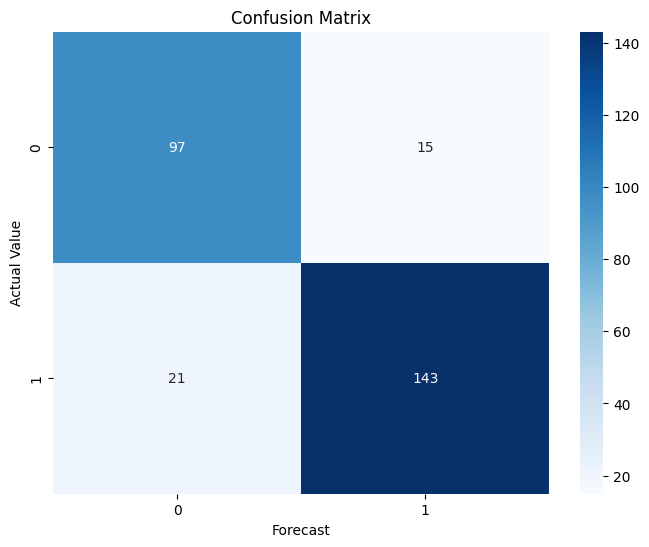

In [63]:
models_list = sorted(models_list, key=lambda d: d['model_accuracy'])
best_model = models_list[-1]
best_model_clf = best_model.get("model_instance")
y_pred = best_model_clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Forecast')
plt.ylabel('Actual Value')
plt.title('Confusion Matrix')
plt.show()

In [64]:
print(best_model)

{'model_name': 'Random Forest', 'model_instance': RandomForestClassifier(criterion='log_loss', max_depth=7, n_estimators=50), 'model_accuracy': 0.8695652173913043, 'train_time': datetime.timedelta(seconds=35, microseconds=937379)}


## ROC curve (AUC)
<p>The AUC is a metric that evaluates the ability of a classification model to distinguish correctly between two classes. It is used to compare models, select relevant features, establish classification thresholds, and monitor performance over time. The AUC curve summarizes the overall quality of the model, regardless of the chosen cutoff point, and it is a widely used measure in the analysis of classifier performance.<p>

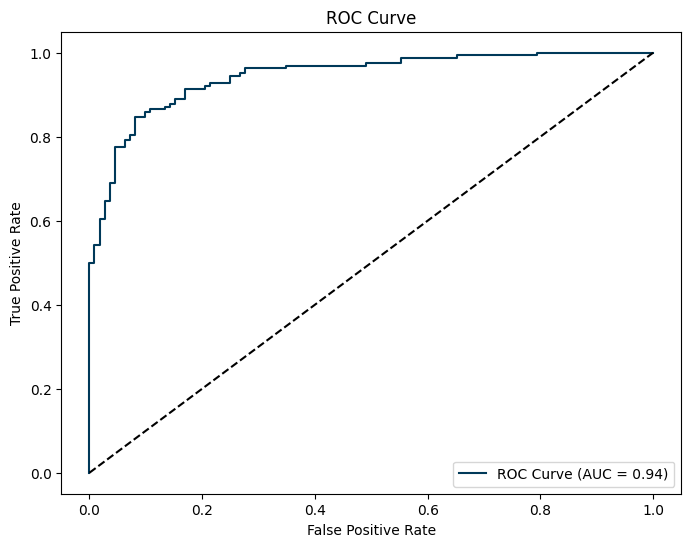

In [65]:
y_prob = best_model_clf.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

<b>Conclusion:</b>

Cardiovascular Risk: Patients with elevated cholesterol levels, blood pressure, and Oldpeak tend to be at higher risk. These factors are known to affect heart health.

Demographic Factors: Age and sex show a clear association, with older men being more affected, consistent with clinical studies.

Specific Clinical Profiles: Changes in ECG, types of chest pain, and exercise-induced angina are significant variables. Asymptomatic individuals and those with flat ST inclination require more medical attention.

The classification model used was Random Forest, implemented with the RandomForestClassifier, configured with the splitting criterion set to entropy and a maximum depth of 7. The model achieved an accuracy of 87.68%, demonstrating robust performance in the classification task. The total training time was approximately 34.78 seconds, reflecting efficient processing.

The model evaluation was conducted through a confusion matrix, which showed that the model correctly classified 94 instances of class 0 and 144 instances of class 1, while recording 14 false positives and 20 false negatives. Additionally, the area under the curve (AUC) was calculated, resulting in 0.94, indicating an excellent ability to discriminate between classes, highlighting the model's effectiveness in predicting correct outcomes.